# Sample Code

## 基礎建設

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-22 12:40:28--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  8.12MB/s    in 1.8s    

2021-12-22 12:40:30 (8.12 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-22 12:40:30--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  6.58MB/s    in 1.5s    

202

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [70]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [71]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 了解資料



1. 測試集中有沒有歷史資料的新客戶。[考量沒歷史資料者怎麼分析]
2. 即使有歷史資料，單人的購買數量基本不多
3. 訓練資料從2000-2018，測試資料只有2018
4. 從訓練資料可看出2017-2018年，評分median為5分者，通常為熱銷款[***]




In [77]:
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

In [101]:
# 使用者群分析-train

attention_products_train = defaultdict(int)
products_overall_train  = defaultdict(lambda: 0)

maxNumber = 0
maxList  = []
for i in range(len(ratings_trainings)):
  user  = ratings_trainings.iloc[i,1]
  product = ratings_trainings.iloc[i,0]
  score  = ratings_trainings.iloc[i,2]
  attention_products_train[product] += 1
  products_overall_train[product] += score
  if maxNumber < attention_products_train[product]:
    maxList = [product]
    maxNumber = attention_products_train[product]
  elif maxNumber == attention_products_train[product]:
    maxList.append(product)
print("MaxNumber = {0}, List = {1}".format(maxNumber, maxList))

attention_list_train = defaultdict(list)
for k, v in attention_products_train.items():
  attention_list_train[v].append(k)

attention_list_train

MaxNumber = 8672, List = ['B000FOI48G']


defaultdict(list,
            {1: ['0692508988',
              '0721917704',
              '0792272595',
              '0967140196',
              '0974158232',
              '0976070502',
              '0977217205',
              '0984893229',
              '1421698315',
              '1465018964',
              '1465055452',
              '1465029818',
              '1488908265',
              '0957664613',
              '1593749880',
              '1613189958',
              '1465058028',
              '1931292108',
              '1932548114',
              '1933228032',
              '1933516372',
              '1465042067',
              '366482864X',
              '3939888141',
              '419881029X',
              '7178680776',
              '7367905066',
              '8637910351',
              '9197882747',
              'B000052YK4',
              'B000052WYR',
              'B0000532E2',
              'B0000537Y8',
              'B0000537I2',
              'B000053876',

In [102]:
# 新使用者群分析
new_users = list(set(ratings_testings["reviewerID"]) - set(ratings_trainings["reviewerID"]))
print("new users number: ",len(new_users))
attention_products = defaultdict(int)
products_overall  = defaultdict(lambda: 0)

maxNumber = 0
maxList  = []
for i in range(len(ratings_testings)):
  user  = ratings_testings.iloc[i,1]
  product = ratings_testings.iloc[i,0]
  score  = ratings_testings.iloc[i,2]
  if user in new_users:
    attention_products[product] += 1
    products_overall[product] += score
    if maxNumber < attention_products[product]:
      maxList = [product]
      maxNumber = attention_products[product]
    elif maxNumber == attention_products[product]:
      maxList.append(product)

print("MaxNumber = {0}, List = {1}".format(maxNumber, maxList))

attention_list = defaultdict(list)
for k, v in attention_products.items():
  attention_list[v].append(k)

attention_list

new users number:  546
MaxNumber = 48, List = ['B01DKQAXC0']


defaultdict(list,
            {1: ['B013L1WT30',
              'B013XKHA4M',
              'B015L947B2',
              'B015P54DHU',
              'B015PFP72A',
              'B015PS18MU',
              'B015PWYO7W',
              'B015SG1BSU',
              'B015XSA29C',
              'B015YL6MYM',
              'B01623MAVA',
              'B0168SXRR0',
              'B016IPPDVQ',
              'B016NX6ZMO',
              'B0174MNPNU',
              'B0176882A8',
              'B0178JC23S',
              'B017BFMTVE',
              'B0064C8CY4',
              'B017IJF730',
              'B017J9EZDW',
              'B017JBTB98',
              'B017JSZKGY',
              'B017M402PO',
              'B017STUIG6',
              'B017TNICB4',
              'B017VGSS6S',
              'B017X2K6R4',
              'B01814GS02',
              'B01826KTDQ',
              'B01868X158',
              'B0189H1QKS',
              'B018BUM4OU',
              'B018DHKYO8',
              'B018IW1T5Q',

In [73]:
ratings_testings['year'] = ratings_testings["DATE"].dt.year
ratings_trainings['year'] = ratings_trainings["DATE"].dt.year

ratings_testings.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,asin,reviewerID,overall,unixReviewTime,DATE,year
234795,B01CJNZKZK,A38KP6TI3BUIM6,1.0,1536192000,2018-09-06,2018
234796,B01CJNZKZK,A2H7VSYLKGKLLJ,1.0,1535932800,2018-09-03,2018
234797,B01CJNZKZK,A1119JJ37ZLB8R,5.0,1535932800,2018-09-03,2018
240438,B01DKQAXC0,A1FKUBRPLG6Y8I,5.0,1537401600,2018-09-20,2018
240439,B01DKQAXC0,A2WX2YLLHJDLX7,5.0,1537315200,2018-09-19,2018


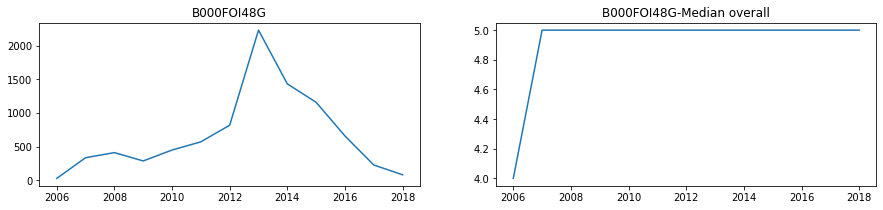

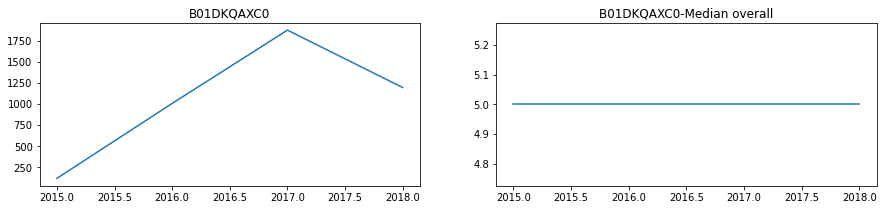

In [125]:
def drawProduct_buyline(productName, df):
  tmp = df[df["asin"] == productName]

  record = {}
  score = {}
  for year in range(min(tmp["year"]), max(tmp["year"])+1):
    a = tmp[tmp["year"]==year]
    # record[year] = [len(a), a["overall"].median()]
    record[year] = [len(a), a["overall"].quantile(.4)]

  tmp = pd.DataFrame.from_dict(record, orient='index').rename(columns={0:'Amount', 1:'Overall'})

  plt.subplot(1, 2, 1)
  tmp["Amount"].plot(title=productName, figsize=(15,3))
  plt.subplot(1, 2, 2)
  tmp["Overall"].plot(title=productName+"-Median overall", figsize=(15,3))
  plt.show()

drawProduct_buyline('B000FOI48G', ratings_trainings)
drawProduct_buyline('B01DKQAXC0', ratings_trainings)

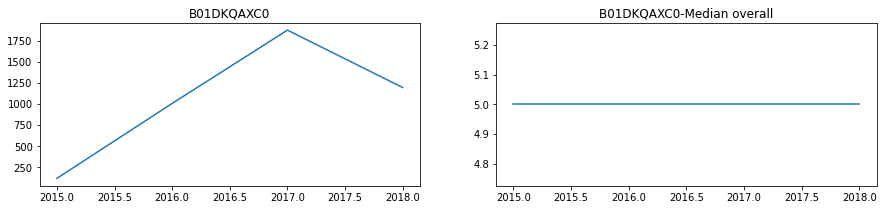

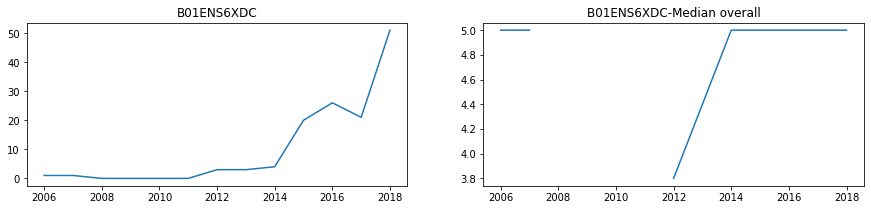

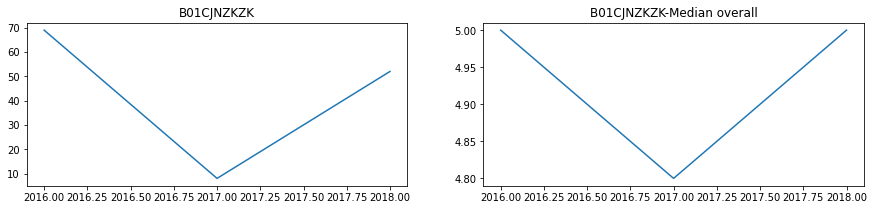

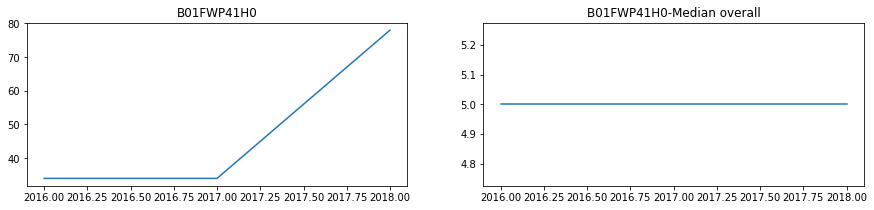

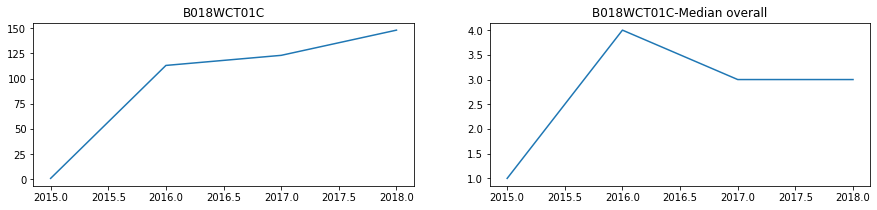

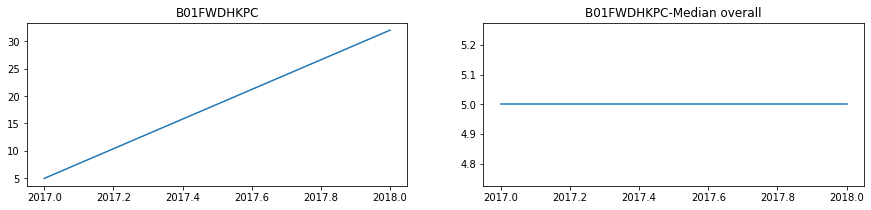

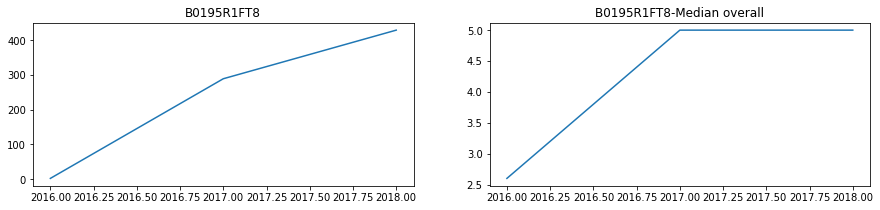

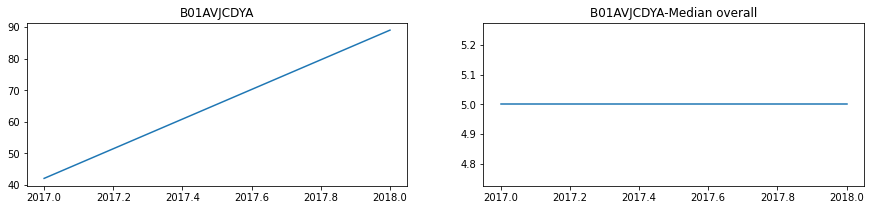

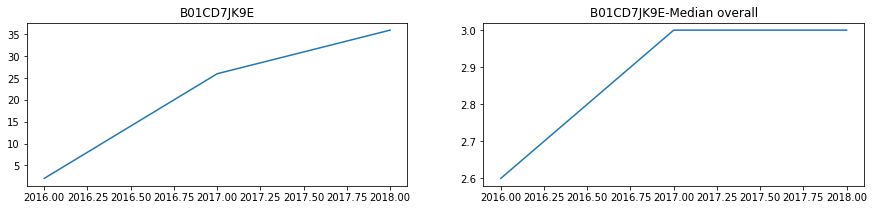

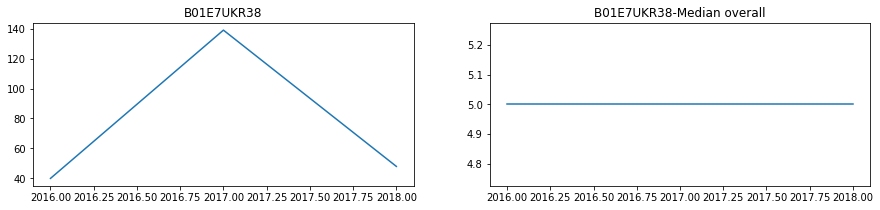

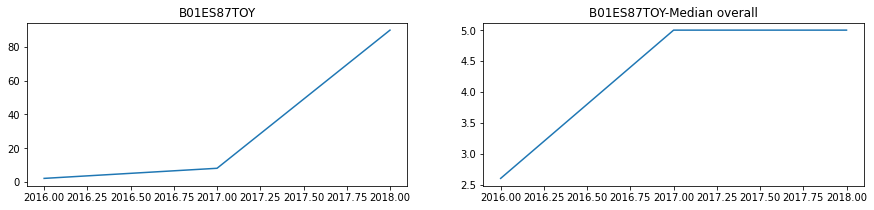

"\n             5: ['B01C4ZAPGM',\n              'B01CTIJEIY',\n              'B01CX5KCIE',\n              'B01DFHDMS6',\n              'B01FT6TMQM'],\n             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],\n             7: ['B0195R1FT8', 'B01AVJCDYA'],\n             9: ['B018WCT01C', 'B01FWDHKPC'],\n             10: ['B01FWP41H0'],\n             13: ['B01CJNZKZK'],\n             14: ['B01ENS6XDC'],\n             48: ['B01DKQAXC0']})\n"

In [126]:
drawProduct_buyline('B01DKQAXC0', ratings_trainings)
drawProduct_buyline('B01ENS6XDC', ratings_trainings)
drawProduct_buyline('B01CJNZKZK', ratings_trainings)
drawProduct_buyline('B01FWP41H0', ratings_trainings)
drawProduct_buyline('B018WCT01C', ratings_trainings)
drawProduct_buyline('B01FWDHKPC', ratings_trainings)
drawProduct_buyline('B0195R1FT8', ratings_trainings)
drawProduct_buyline('B01AVJCDYA', ratings_trainings)
drawProduct_buyline('B01CD7JK9E', ratings_trainings)
drawProduct_buyline('B01E7UKR38', ratings_trainings)
drawProduct_buyline('B01ES87TOY', ratings_trainings)

"""
             5: ['B01C4ZAPGM',
              'B01CTIJEIY',
              'B01CX5KCIE',
              'B01DFHDMS6',
              'B01FT6TMQM'],
             6: ['B01CD7JK9E', 'B01E7UKR38', 'B01ES87TOY'],
             7: ['B0195R1FT8', 'B01AVJCDYA'],
             9: ['B018WCT01C', 'B01FWDHKPC'],
             10: ['B01FWP41H0'],
             13: ['B01CJNZKZK'],
             14: ['B01ENS6XDC'],
             48: ['B01DKQAXC0']})
"""

In [127]:
current_trainings = ratings_trainings[(ratings_trainings['DATE'] >= '2018-07-01') & (ratings_trainings['DATE'] <= '2018-09-01')]

groups = current_trainings.groupby("asin")
tmp   = groups["overall"].median()
current_score5_products = list(tmp[tmp==5].index)
print("current total = "+str(len(current_score5_products)))

# ====
lastyear_trainings = ratings_trainings[(ratings_trainings['DATE'] >= '2017-08-01') & (ratings_trainings['DATE'] <= '2017-11-01')]

groups = lastyear_trainings.groupby("asin")
# tmp   = groups["overall"].median()
tmp   = groups["overall"].quantile(.4)
lastyear_score5_products = list(tmp[tmp==5].index)
print("lastyear total = "+str(len(lastyear_score5_products)))

print("Overlap = ",len(set(current_score5_products) & set(lastyear_score5_products)))

current total = 975
lastyear total = 2570
Overlap =  307


In [116]:
current_trainings.head()

,asin,reviewerID,overall,unixReviewTime,DATE,year
7,014789302X,A26PO1B2Q2G1CS,1.0,1491782400,2017-04-10,2017
32,1620213982,A9KCT397IWK97,5.0,1525737600,2018-05-08,2018
33,1620213982,A36Z95ZFDMNL99,5.0,1525737600,2018-05-08,2018
34,1620213982,AB6RYXLZSKHIR,5.0,1525564800,2018-05-06,2018
35,1620213982,A210V878QFZW9V,5.0,1525305600,2018-05-03,2018


In [26]:
ratings_trainings[ratings_trainings["reviewerID"] == "A13JU88JAHN72I"]

,asin,reviewerID,overall,unixReviewTime,DATE
281656,B009YDVB6Q,A13JU88JAHN72I,2.0,1391990400,2014-02-10


In [27]:
ratings_testings[ratings_testings["reviewerID"] == "A13JU88JAHN72I"]

,asin,reviewerID,overall,unixReviewTime,DATE
343283,B017I6B6GK,A13JU88JAHN72I,4.0,1536710400,2018-09-12


In [31]:
tmp = metadata[(metadata["asin"] == "B009YDVB6Q") | (metadata["asin"] == "B017I6B6GK")]
tmp.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
7466,[],,[],,"Gift Idea,Hoter White Rose Stud Earrings, Pric...",[],,,[],"1,595,475 in Beauty & Personal Care (",[],{'ASIN: ': 'B009YDVB6Q'},All Beauty,,,,B009YDVB6Q,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
25091,[],,[],,Root Concealer (Black/Dark Brown) 2oz by Style...,"[B00GBE80W4, B00R0I50LO, B013XGBDBW, B01648QP3...",,,[],"368,827 in Beauty & Personal Care (",[B07CLP8ZHY],"{'Shipping Weight:': '6.4 ounces', 'ASIN: ': '...",All Beauty,,,,B017I6B6GK,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [35]:
tmp["also_buy"].iloc[1]

['B00GBE80W4', 'B00R0I50LO', 'B013XGBDBW', 'B01648QP3W', 'B00TUPTZNE']

## 產生推薦

In [9]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    Your Code
    '''
    return recommendations


ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{}

## 結果評估

In [10]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0